<a href="https://colab.research.google.com/github/pritika-vig/modeling-adrs/blob/main/all_models_adr_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


!pip install imbalanced-learn xgboost scikit-learn pandas matplotlib seaborn --quiet


In [ ]:
!pip install lightgbm


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, roc_curve
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
import shap
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression


In [ ]:
# Load initial data frame
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/physionet/adr_features_with_subclass_labels.csv'
df = pd.read_csv(file_path)
print("Loaded data:", df.shape)
df.columns

Mounted at /content/drive
Loaded data: (17277, 438)


Index(['ADR', 'subject_id', 'hadm_id', 'icustay_id', 'window_start',
       'window_end', 'gender', 'age', 'ethnicity', 'admission_type',
       ...
       'Drain Out #1 Jackson Pratt_y', 'Chest Tubes CTICU CT 1_y',
       'Chest Tubes Other_y', 'Ultrafiltrate Ultrafiltrate_y',
       'Urine Out Suprapubic_y', 'Chest Tubes CTICU CT 2_y', 'Protonix gtt_y',
       'Urine ._y', 'cerebral drain right_y', 'NA Acetate/H2O_y'],
      dtype='object', length=438)

In [ ]:
y = df['ADR']
# Feature matrix
X = df.drop(columns=[
'subject_id', 'hadm_id', 'window_start', 'window_end', 'ADR', 'ethnicity', 'icustay_id'
] + [col for col in df.columns if col.startswith('ADR_ICD_')])
X.columns
X.isna().any(axis=1).sum()
# Identify categorical and numeric columns
print(X.columns)
categorical_cols = ['gender', 'admission_type']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Leave the numeric columns untouched
)

# Apply preprocessing
X = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
X = pd.DataFrame(X, columns=feature_names)

Index(['gender', 'age', 'admission_type', 'has_drug_allergy_history',
       'ICD_9671', 'ICD_9604', 'ICD_9390', 'ICD_9672', 'ICD_3995', 'ICD_4275',
       ...
       '54', '55', '56', '57', '58', '59', '60', '61', '62', '63'],
      dtype='object', length=488)


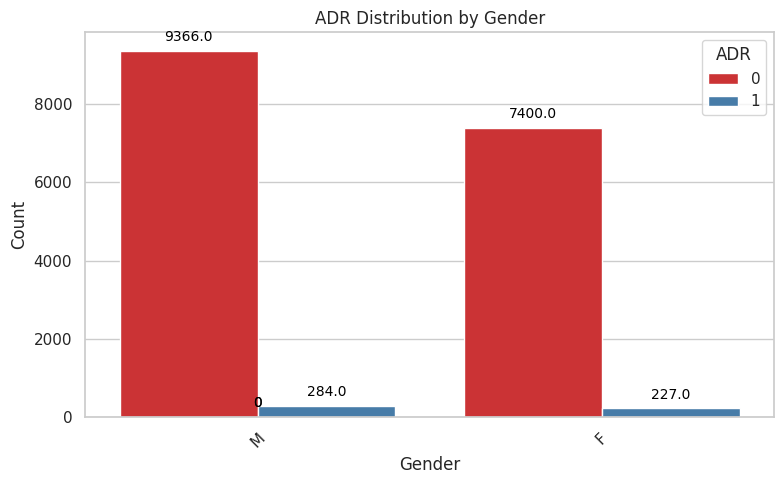

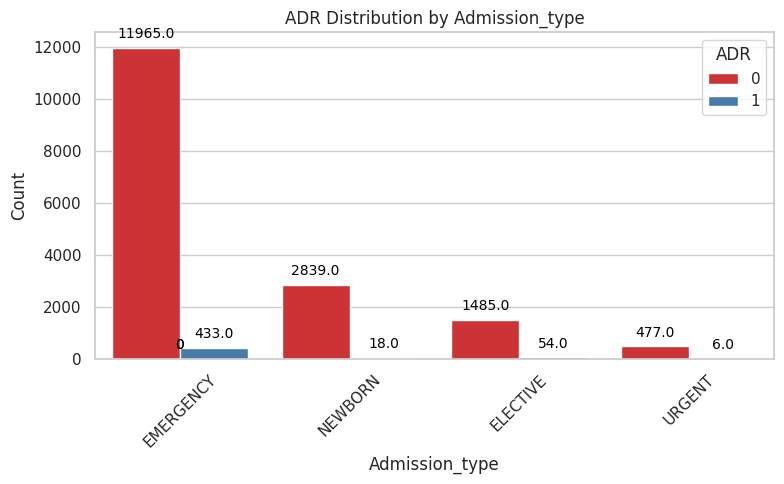

<Figure size 1200x600 with 0 Axes>

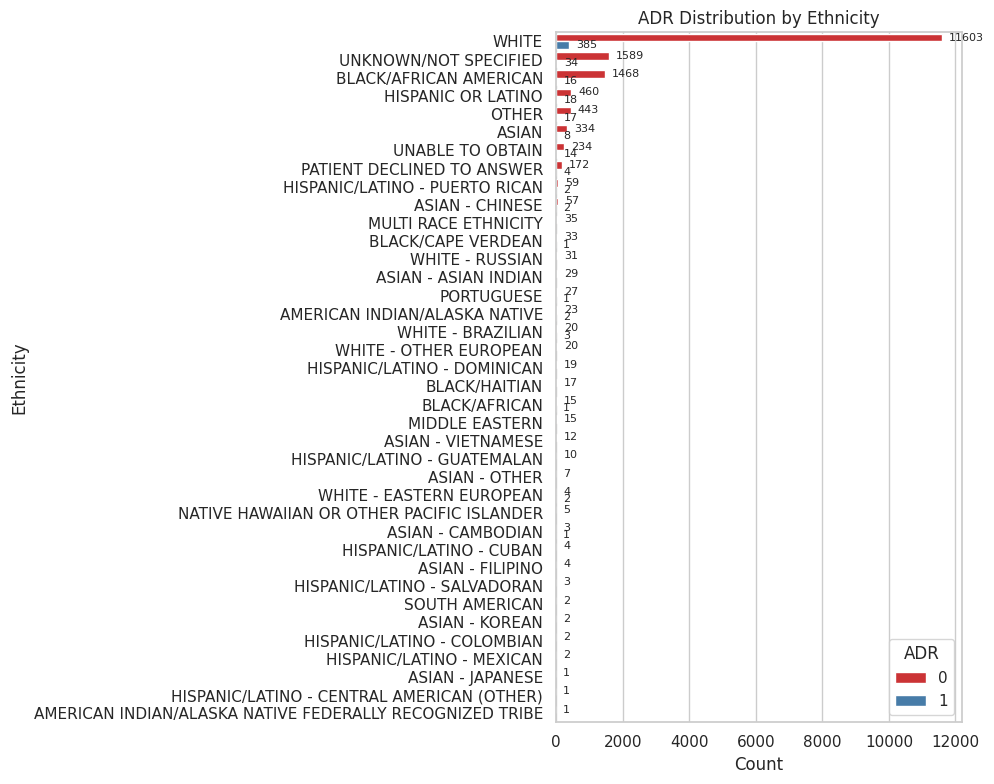

In [ ]:
# Visualize the data across demographic dimensions
demographics = ['gender', 'admission_type']

# Set style
sns.set(style="whitegrid")

# Loop through each demographic variable
for col in demographics:
    plt.figure(figsize=(8, 5))

    # Create a count plot
    ax = sns.countplot(data=df, x=col, hue='ADR', palette='Set1')

    # Add value annotations
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

    # Labeling
    plt.title(f'ADR Distribution by {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='ADR', loc='upper right')
    plt.tight_layout()
    plt.show()
plt.figure(figsize=(12, 6))  # Wider figure for more space

plt.figure(figsize=(10, 8))
ax = sns.countplot(data=df, y='ethnicity', hue='ADR', palette='Set1', order=df['ethnicity'].value_counts().index)

# Add annotations
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.annotate(f'{int(width)}', (width, p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=8, xytext=(5, 0), textcoords='offset points')

plt.title('ADR Distribution by Ethnicity')
plt.xlabel('Count')
plt.ylabel('Ethnicity')
plt.legend(title='ADR', loc='lower right')
plt.tight_layout()
plt.show()


In [ ]:
def evaluation_metrics(y_val, y_val_prob, threshold, show_auc_plot = True):
  y_val_pred = (y_val_prob >= threshold).astype(int)
  print("\nClassification Report:")
  print(classification_report(y_val, y_val_pred))
  # Generate confusion matrix
  cm = confusion_matrix(y_val, y_val_pred)
  cm_df = pd.DataFrame(cm,
                     index=['Actual Negative', 'Actual Positive'],
                     columns=['Predicted Negative', 'Predicted Positive'])

  print("\nConfusion Matrix:")
  print(cm_df)

  roc_auc = roc_auc_score(y_val, y_val_prob)
  print("ROC AUC:", roc_auc)

  precision, recall, _ = precision_recall_curve(y_val, y_val_prob)
  pr_auc = auc(recall, precision)
  if show_auc_plot:
    print("PR AUC:", pr_auc)

    plt.figure()
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

  print("\nPredicted probabilities for true ADR 1:")
  df_val = pd.DataFrame({'true': y_val, 'prob': y_val_prob})
  print(df_val[df_val['true'] == 1])


  # Filter predictions for true class 0
  non_adr_probs = y_val_prob[y_val == 0]
  summary = {
    "mean": np.mean(non_adr_probs),
    "std": np.std(non_adr_probs),
    "min": np.min(non_adr_probs),
    "max": np.max(non_adr_probs),
    "median": np.median(non_adr_probs),
    "quantile_25": np.quantile(non_adr_probs, 0.25),
    "quantile_75": np.quantile(non_adr_probs, 0.75),
  }

  # Print results
  print("\nNon-ADR Predicted Probability Summary:")
  for k, v in summary.items():
      print(f"{k}: {v:.4f}")

In [ ]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def shap_explanation(model, X, top_n=20):
    """
    Generate SHAP visualizations: positive/negative bar chart and interaction plot.

    Parameters:
    - model: trained model (compatible with SHAP)
    - X: pandas DataFrame of input features
    - top_n: number of top features to show (default=20)
    """
    import shap
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    print("Explaining model...")
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)

    # Extract raw SHAP values safely as NumPy array
    shap_vals = shap_values.values
    if isinstance(shap_vals, list):  # For some multiclass models
        shap_vals = shap_vals[0]

    shap_vals = np.array(shap_vals)  # Ensure it's a NumPy array
    feature_names = X.columns

    # Compute mean positive and negative contributions
    mean_positive = (shap_vals * (shap_vals > 0)).mean(axis=0)
    mean_negative = (shap_vals * (shap_vals < 0)).mean(axis=0)

    # Create DataFrame for bar plot
    shap_df = pd.DataFrame({
        "feature": feature_names,
        "mean_positive": mean_positive,
        "mean_negative": mean_negative
    }).sort_values(by=["mean_positive", "mean_negative"], ascending=[False, True]).head(top_n)

    # Plot positive vs. negative contribution
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(shap_df["feature"], shap_df["mean_positive"], color="red", label="Positive impact")
    ax.barh(shap_df["feature"], shap_df["mean_negative"], color="blue", label="Negative impact")
    ax.set_xlabel("Mean SHAP value")
    ax.set_title("Mean Positive vs. Negative SHAP Values by Feature")
    ax.legend()
    plt.tight_layout()
    plt.gca().invert_yaxis()  # Most important feature on top
    plt.show()

    # Feature interaction plot
    print("Showing SHAP interaction plot...")
    # Find column index directly to avoid name matching issues
    top_feature = shap_df.iloc[0]["feature"]
    feature_index = list(X.columns).index(top_feature)
    shap.dependence_plot(top_feature, shap_values.values, X, interaction_index="auto")



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax

def plot_confidence_histogram(logits, true_labels, class_names=None, title="Confidence Histogram"):
    """
    Plots a histogram of predicted confidences, distinguishing correct and incorrect predictions.

    Args:
        logits (np.ndarray): Array of shape (n_samples, n_classes) with raw model outputs.
        true_labels (np.ndarray): Array of shape (n_samples,) with true class indices.
        class_names (list, optional): List of class names corresponding to class indices.
        title (str, optional): Title of the plot.
    """
    # Convert logits to probabilities
    probs = softmax(logits, axis=1)
    pred_labels = np.argmax(probs, axis=1)
    confidences = np.max(probs, axis=1)
    correct = pred_labels == true_labels

    # Create plot
    plt.figure(figsize=(8, 5))
    sns.histplot(x=confidences, hue=correct, bins=20, palette={True: "green", False: "red"}, kde=False)

    plt.xlabel("Predicted Confidence")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.legend(title="Correct", labels=["Incorrect", "Correct"])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_prec_recall(all_precisions, all_avg_precisions, recall_points):
    mean_precision = np.mean(all_precisions, axis=0)
    std_precision = np.std(all_precisions, axis=0)
    mean_avg_precision = np.mean(all_avg_precisions)

    plt.figure(figsize=(8, 6))
    plt.plot(recall_points, mean_precision, label=f'Mean PR (AP = {mean_avg_precision:.2f})')
    plt.fill_between(recall_points,
                     mean_precision - std_precision,
                     mean_precision + std_precision,
                     alpha=0.2,
                     label='±1 std dev')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average Precision-Recall Curve (5-Fold CV)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Collects ADR subgroup scores from each fold
def collect_adr_probs_by_subgroup(X_val, y_val, y_val_prob, features_df, adr_icd_cols, adr_subgroup_scores):
    val_results = X_val.copy()
    val_results['y_val_prob'] = y_val_prob
    val_results['true_label'] = y_val.values
    val_results = val_results.rename(columns={'remainder__icustay_id': 'icustay_id'})
    val_results = val_results.merge(df[['icustay_id'] + adr_icd_cols], on='icustay_id', how='left')

    for col in adr_icd_cols:
        if col in val_results:
            avg_prob = val_results.loc[val_results[col] == 1, 'y_val_prob'].mean()
            if not np.isnan(avg_prob):
                adr_subgroup_scores[col].append(avg_prob)

def plot_avg_adr_probs(adr_subgroup_scores):
    import matplotlib.pyplot as plt
    import numpy as np

    # Compute means, stds, and counts
    mean_probs = {k: np.mean(v) for k, v in adr_subgroup_scores.items() if v}
    std_devs = {k: np.std(v) for k, v in adr_subgroup_scores.items() if v}
    counts = {k: len(v) for k, v in adr_subgroup_scores.items() if v}

    # Sort by mean predicted prob
    sorted_keys = sorted(mean_probs, key=mean_probs.get, reverse=True)
    means = [mean_probs[k] for k in sorted_keys]
    stds = [std_devs[k] for k in sorted_keys]
    n_samples = [counts[k] for k in sorted_keys]

    # Create plot
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.barh(sorted_keys, means, xerr=stds, color='skyblue', edgecolor='black')
    ax1.set_xlabel("Average Predicted ADR Probability")
    ax1.set_title("Model Confidence by ADR Type (+ Std Dev)")
    ax1.invert_yaxis()

    # Add a second axis to show sample counts
    ax2 = ax1.twiny()
    ax2.plot(n_samples, sorted_keys, 'r.', label="# of Samples")
    ax2.set_xlabel("Number of Patients with ADR Type")

    plt.tight_layout()
    plt.show()
def plot_mean_roc_curve(all_fpr, all_tpr, fpr_points):
    """
    Plots the mean ROC curve across multiple folds.

    Parameters:
    - all_fpr: List of interpolated FPR arrays for each fold
    - all_tpr: List of interpolated TPR arrays for each fold
    - fpr_points: Uniformly spaced FPR points used for interpolation
    """
    mean_tpr = np.mean(all_tpr, axis=0)
    mean_tpr[-1] = 1.0  # Ensure curve ends at 1
    mean_auc = auc(fpr_points, mean_tpr)
    std_tpr = np.std(all_tpr, axis=0)

    plt.figure()
    plt.plot(fpr_points, mean_tpr, label=f"Mean ROC (AUC = {mean_auc:.2f})", lw=2)
    plt.fill_between(fpr_points, mean_tpr - std_tpr, mean_tpr + std_tpr, alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curve Across Folds')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

Strategy #1: SMOTE with XGBoost, with scaled weighting for class prediction

In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

def find_best_f1_threshold(y_true, y_scores):
    """
    Finds the threshold that maximizes F1-score from predicted probabilities.

    Parameters:
    - y_true: Ground truth binary labels (array-like)
    - y_scores: Predicted probabilities for the positive class (array-like)

    Returns:
    - best_threshold: Threshold that gives the highest F1 score
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # Avoid division by zero
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index] if best_index < len(thresholds) else 0.5  # thresholds is len - 1

    print(f"Best F1 Threshold: {best_threshold:.4f}")
    print(f"Precision: {precisions[best_index]:.4f}, Recall: {recalls[best_index]:.4f}, F1: {f1_scores[best_index]:.4f}")

    return best_threshold


In [ ]:

def compute_predictions(model, X_train, y_train, X_val):
    model.fit(X_train, y_train)
    return model.predict_proba(X_val)[:, 1]

def interpolate_metrics(y_true, y_scores, recall_points):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)
    interp_precision = np.interp(recall_points, recall[::-1], precision[::-1])

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    interp_tpr = np.interp(recall_points, fpr, tpr)
    interp_tpr[0] = 0.0

    return interp_precision, avg_precision, interp_tpr

def evaluate_threshold_metrics(y_true, y_scores, threshold):
    y_pred = (y_scores >= threshold).astype(int)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_scores)
    return precision, recall, f1, roc_auc

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_calibration_curve(y_true, y_prob, n_bins=10, title="Calibration Plot"):
    """
    Plots a calibration curve to show how well predicted probabilities match actual outcomes.

    Args:
        y_true (np.ndarray): True binary labels (0 or 1).
        y_prob (np.ndarray): Predicted probabilities for the positive class.
        n_bins (int): Number of bins to group predictions.
        title (str): Title for the plot.
    """
    # Ensure y_prob is 1D (for binary classification)
    if y_prob.ndim > 1 and y_prob.shape[1] == 2:
        y_prob = y_prob[:, 1]

    # Get calibration curve
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')

    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Best F1 Threshold: 0.8791
Precision: 0.9340, Recall: 0.9802, F1: 0.9565
batch # 1

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3647
           1       0.93      0.98      0.96       101

    accuracy                           1.00      3748
   macro avg       0.97      0.99      0.98      3748
weighted avg       1.00      1.00      1.00      3748


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                3640                   7
Actual Positive                   2                  99
ROC AUC: 0.998629010145325

Predicted probabilities for true ADR 1:
       true      prob
77        1  0.998530
123       1  0.999841
432       1  0.973944
458       1  0.982269
495       1  0.998436
...     ...       ...
17167     1  0.999776
17785     1  0.997199
17805     1  0.999514
18087     1  0.999480
18259     1  0.999260

[101 rows x 2 columns]

Non-ADR Predicted Proba

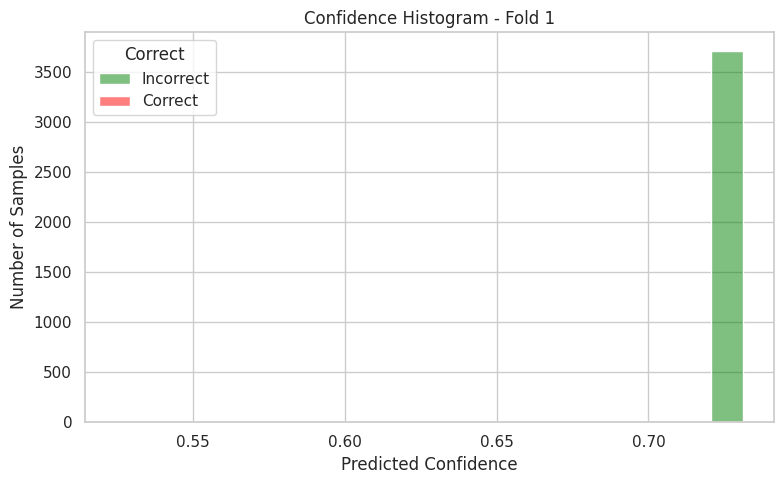

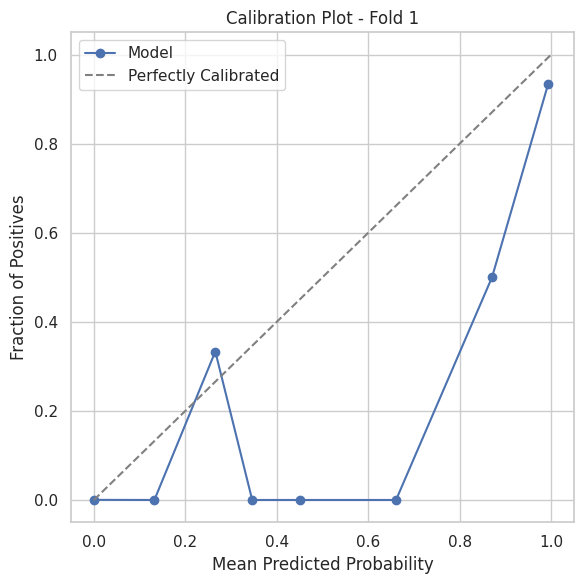

Best F1 Threshold: 0.9062
Precision: 0.9515, Recall: 0.9608, F1: 0.9561
batch # 2

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3646
           1       0.95      0.96      0.96       102

    accuracy                           1.00      3748
   macro avg       0.98      0.98      0.98      3748
weighted avg       1.00      1.00      1.00      3748


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                3641                   5
Actual Positive                   4                  98
ROC AUC: 0.9993331397287385

Predicted probabilities for true ADR 1:
       true      prob
236       1  0.999835
381       1  0.999549
582       1  0.999947
588       1  0.999627
759       1  0.999957
...     ...       ...
17031     1  0.999513
17141     1  0.999740
17233     1  0.999685
17824     1  0.101675
17893     1  0.999923

[102 rows x 2 columns]

Non-ADR Predicted Prob

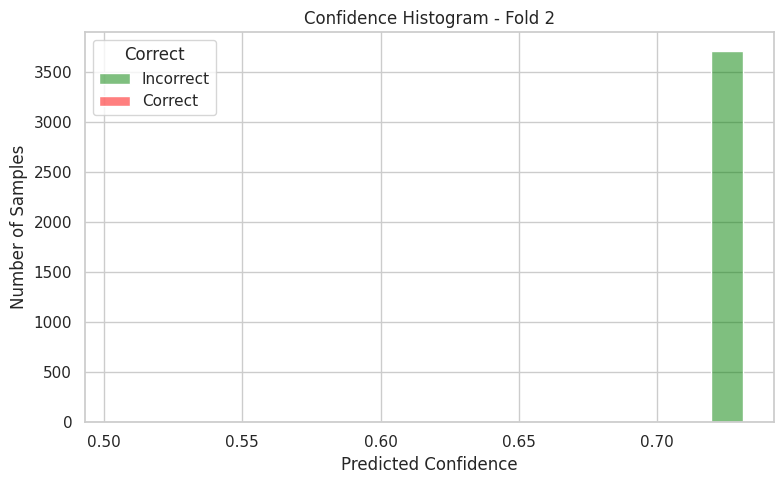

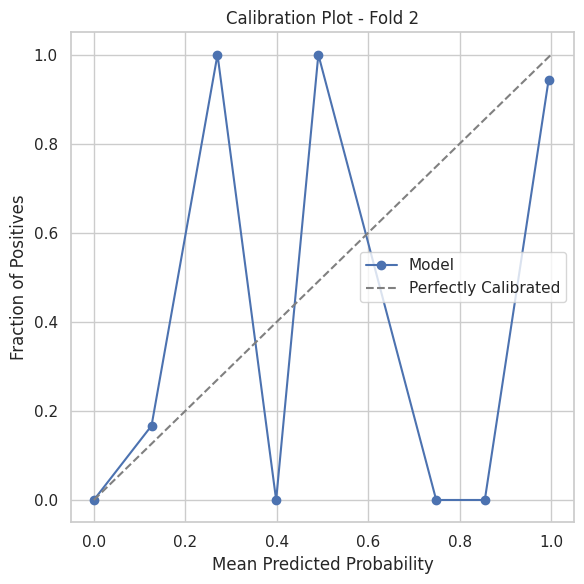

Best F1 Threshold: 0.3414
Precision: 0.9608, Recall: 0.9608, F1: 0.9608
batch # 3

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3646
           1       0.96      0.96      0.96       102

    accuracy                           1.00      3748
   macro avg       0.98      0.98      0.98      3748
weighted avg       1.00      1.00      1.00      3748


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                3642                   4
Actual Positive                   4                  98
ROC AUC: 0.9996316134791822

Predicted probabilities for true ADR 1:
       true      prob
321       1  0.999079
366       1  0.996723
491       1  0.999787
637       1  0.998446
656       1  0.992852
...     ...       ...
15765     1  0.986246
15895     1  0.999833
17207     1  0.999730
17565     1  0.997111
17575     1  0.999653

[102 rows x 2 columns]

Non-ADR Predicted Prob

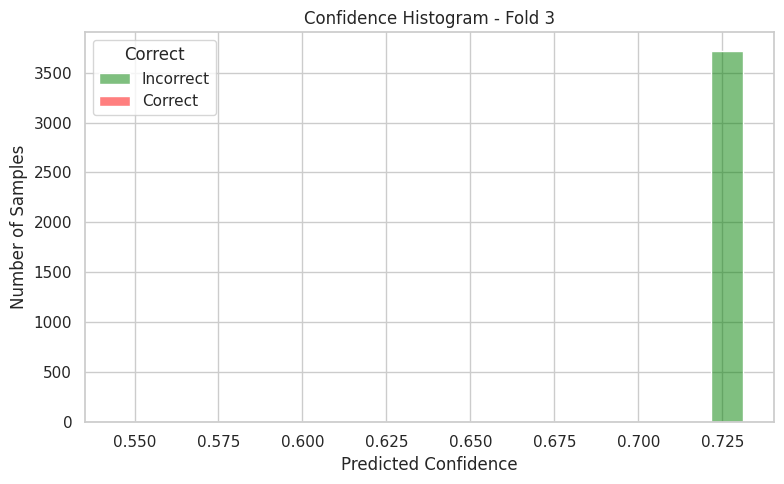

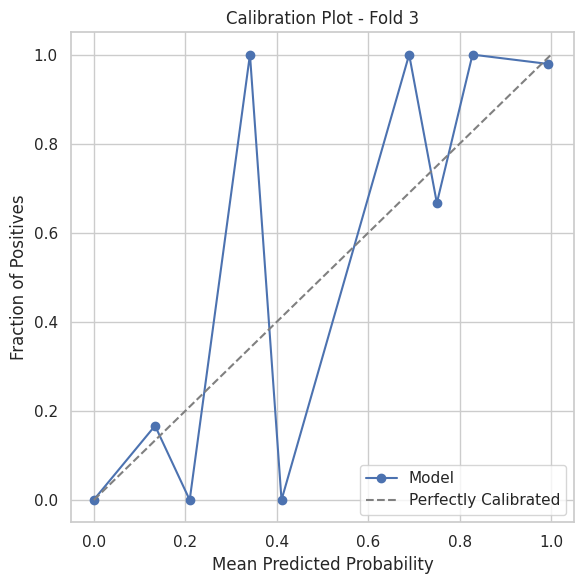

Best F1 Threshold: 0.5480
Precision: 0.9266, Recall: 0.9902, F1: 0.9573
batch # 4

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3646
           1       0.93      0.99      0.96       102

    accuracy                           1.00      3748
   macro avg       0.96      0.99      0.98      3748
weighted avg       1.00      1.00      1.00      3748


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                3638                   8
Actual Positive                   1                 101
ROC AUC: 0.9996934593914362

Predicted probabilities for true ADR 1:
       true      prob
146       1  0.999932
346       1  0.998425
411       1  0.997396
434       1  0.916077
454       1  0.995450
...     ...       ...
17383     1  0.999581
17779     1  0.999695
17814     1  0.974530
18025     1  0.999822
18708     1  0.952735

[102 rows x 2 columns]

Non-ADR Predicted Prob

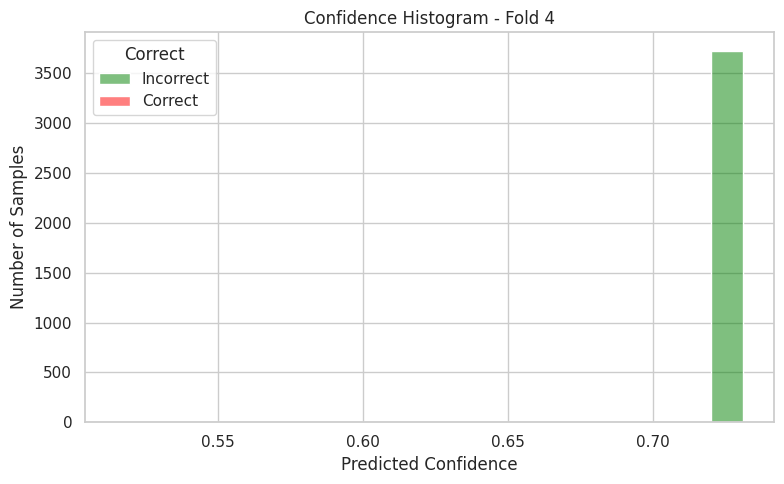

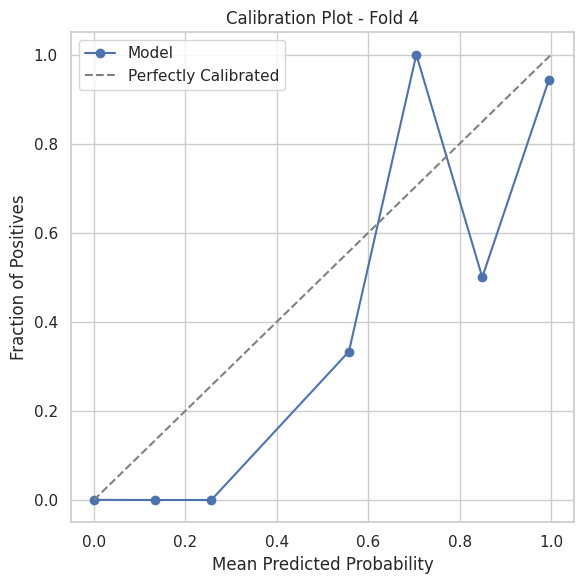

Best F1 Threshold: 0.9275
Precision: 0.9519, Recall: 0.9706, F1: 0.9612
batch # 5

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3646
           1       0.95      0.97      0.96       102

    accuracy                           1.00      3748
   macro avg       0.98      0.98      0.98      3748
weighted avg       1.00      1.00      1.00      3748


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                3641                   5
Actual Positive                   3                  99
ROC AUC: 0.9993573403030988

Predicted probabilities for true ADR 1:
       true      prob
86        1  0.026497
94        1  0.990853
139       1  0.999639
144       1  0.999716
522       1  0.999888
...     ...       ...
17178     1  0.974792
17252     1  0.999142
17415     1  0.953107
17844     1  0.999841
17924     1  0.999491

[102 rows x 2 columns]

Non-ADR Predicted Prob

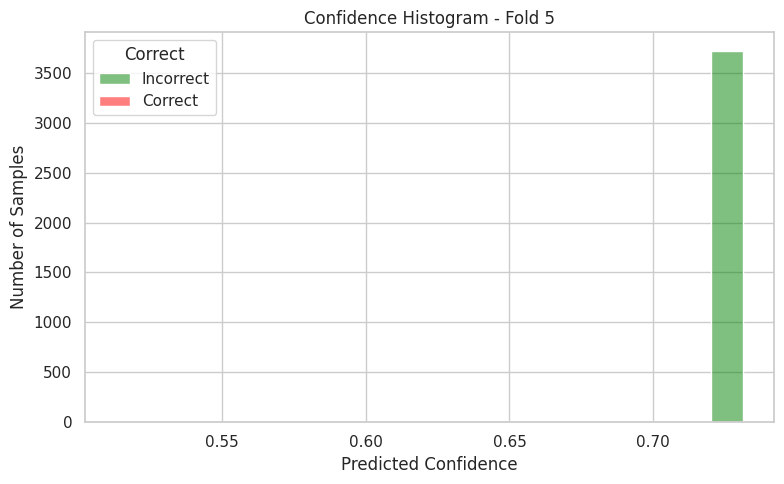

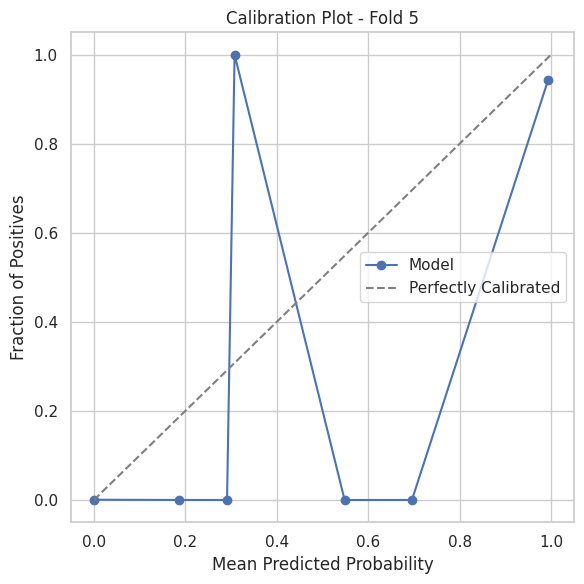

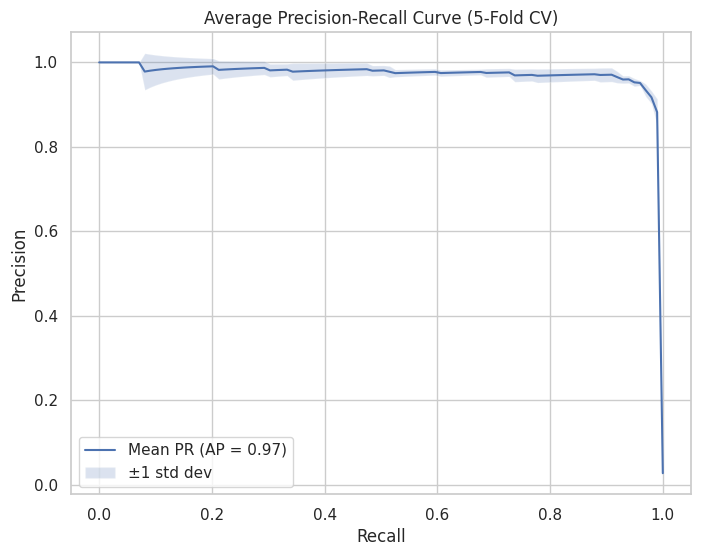

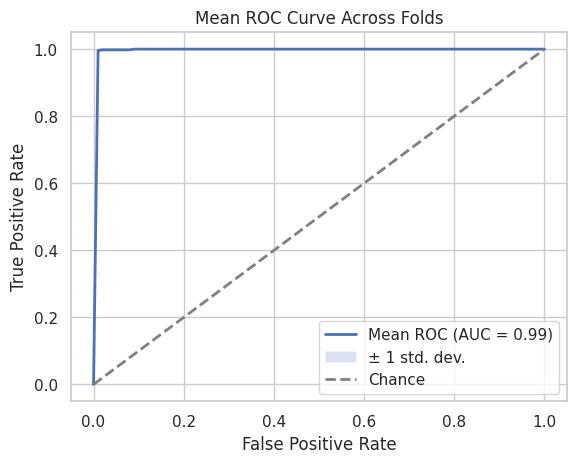


Overall Performance Across 5 Folds:
Average Precision: 0.9449 ± 0.0126
Average Recall:    0.9725 ± 0.0114
Average F1-score:  0.9584 ± 0.0022
Average ROC AUC:   0.9993 ± 0.0004


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:

## Best model so far
# Set with SMOTomek 70/30, and scale_pos_weight 1

#.2, 1, depth 3, threshold .05
# Average Precision: 0.1020 ± 0.0059
# Average Recall:    0.6066 ± 0.0416
# Average F1-score:  0.1746 ± 0.0100
# Average ROC AUC:   0.8108 ± 0.0117
# .2, 1 depth 4
# Overall Performance Across 5 Folds:
# Average Precision: 0.1047 ± 0.0069
# Average Recall:    0.5440 ± 0.0523
# Average F1-score:  0.1756 ± 0.0120
# Average ROC AUC:   0.8108 ± 0.0144
# Overall Performance Across 5 Folds:
# Average Precision: 0.1107 ± 0.0045
# Average Recall:    0.6811 ± 0.0357
# Average F1-score:  0.1905 ± 0.0080
# Average ROC AUC:   0.8425 ± 0.0110
def smotomek_xgboost(X, y):
  model = None
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  precision_list = []
  recall_list = []
  f1_list = []
  roc_auc_list = []
  all_precisions = []
  all_recalls = []
  all_avg_precisions = []
  all_tprs = []

  # Define a uniform set of recall points for interpolation
  recall_points = np.linspace(0, 1, 100)

  batch_no = 0
  for train_index, val_index in skf.split(X, y):
      batch_no += 1
      X_train, X_val = X.iloc[train_index], X.iloc[val_index]
      y_train, y_val = y.iloc[train_index], y.iloc[val_index]

      smt = SMOTETomek(sampling_strategy=0.3, random_state=42)
      X_resampled, y_resampled = smt.fit_resample(X_train, y_train)


      model = xgb.XGBClassifier(
      eval_metric='logloss',
      scale_pos_weight=1,
      learning_rate=0.05,
      max_depth=3,
      n_estimators=300,
      subsample=0.8,
      colsample_bytree=0.8,
      random_state=42
      )

      y_val_prob = compute_predictions(model, X_resampled, y_resampled, X_val)
      threshold = find_best_f1_threshold(y_val, y_val_prob)
      print(f"batch # {batch_no}")
      evaluation_metrics(y_val, y_val_prob, threshold, show_auc_plot=False)
      if y_val_prob.ndim == 1:
    # Binary classification: convert to 2D pseudo-prob array [1 - p, p]
        probs = np.vstack([1 - y_val_prob, y_val_prob]).T
      else:
        probs = y_val_prob
      plot_confidence_histogram(logits=probs, true_labels=y_val.values, title=f"Confidence Histogram - Fold {batch_no}")
      plot_calibration_curve(y_val, y_val_prob, title=f"Calibration Plot - Fold {batch_no}")

      # Collect metrics for avg prec recall curv
      interp_precision, avg_precision, interp_tpr = interpolate_metrics(y_val, y_val_prob, recall_points)
      all_precisions.append(interp_precision)
      all_avg_precisions.append(avg_precision)
      all_tprs.append(interp_tpr)

      precision, recall, f1, auc_score = evaluate_threshold_metrics(y_val, y_val_prob, threshold)
      precision_list.append(precision)
      recall_list.append(recall)
      f1_list.append(f1)
      roc_auc_list.append(auc_score)
      #shap_explanation(model, X_resampled)

      #shap_explanation(model, X_resampled, X_val.drop(columns=['remainder__icustay_id']))
  plot_prec_recall(all_precisions, all_avg_precisions, recall_points)
  plot_mean_roc_curve(all_fpr=recall_points, all_tpr=all_tprs, fpr_points=recall_points)



  print("\nOverall Performance Across 5 Folds:")
  print(f"Average Precision: {np.mean(precision_list):.4f} ± {np.std(precision_list):.4f}")
  print(f"Average Recall:    {np.mean(recall_list):.4f} ± {np.std(recall_list):.4f}")
  print(f"Average F1-score:  {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")
  print(f"Average ROC AUC:   {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")
  return model

smotomek_xgboost(X, y)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def smotomek_logreg(X, y):
    model = None
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    threshold = 0.1
    recall_points = np.linspace(0, 1, 100)

    precision_list, recall_list, f1_list, roc_auc_list = [], [], [], []
    all_precisions, all_avg_precisions, all_tprs = [], [], []

    for batch_no, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        smt = SMOTETomek(sampling_strategy=0.3, random_state=42)
        X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

        # model = LogisticRegression(
        #     penalty='l2',
        #     solver='lbfgs',
        #     max_iter=1000,
        #     random_state=42
        # )

        model = Pipeline([
          ("scaler", StandardScaler()),
          ("logreg", LogisticRegression(
            penalty='l2',
            solver='lbfgs',
            max_iter=1000,
            random_state=42
        ))
        ])
        y_val_prob = compute_predictions(model, X_resampled, y_resampled, X_val)
        threshold = find_best_f1_threshold(y_val, y_val_prob)
        print(f"batch # {batch_no}")
        evaluation_metrics(y_val, y_val_prob, threshold, show_auc_plot=False)

        interp_precision, avg_precision, interp_tpr = interpolate_metrics(y_val, y_val_prob, recall_points)
        all_precisions.append(interp_precision)
        all_avg_precisions.append(avg_precision)
        all_tprs.append(interp_tpr)

        precision, recall, f1, auc_score = evaluate_threshold_metrics(y_val, y_val_prob, threshold)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        roc_auc_list.append(auc_score)

    plot_prec_recall(all_precisions, all_avg_precisions, recall_points)
    plot_mean_roc_curve(all_fpr=recall_points, all_tpr=all_tprs, fpr_points=recall_points)

    print("\nOverall Performance Across 5 Folds (Logistic Regression):")
    print(f"Average Precision: {np.mean(precision_list):.4f} ± {np.std(precision_list):.4f}")
    print(f"Average Recall:    {np.mean(recall_list):.4f} ± {np.std(recall_list):.4f}")
    print(f"Average F1-score:  {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")
    print(f"Average ROC AUC:   {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")
    return model


Best F1 Threshold: 0.9112
Precision: 0.9175, Recall: 0.8725, F1: 0.8945
batch # 1

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3354
           1       0.92      0.87      0.89       102

    accuracy                           0.99      3456
   macro avg       0.96      0.94      0.95      3456
weighted avg       0.99      0.99      0.99      3456


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                3346                   8
Actual Positive                  13                  89
ROC AUC: 0.9805383095396776

Predicted probabilities for true ADR 1:
       true      prob
417       1  1.000000
562       1  0.937221
780       1  1.000000
892       1  0.992796
1035      1  1.000000
...     ...       ...
16214     1  0.967131
16235     1  0.999962
16248     1  1.000000
16897     1  1.000000
17216     1  0.741565

[102 rows x 2 columns]

Non-ADR Predicted Prob

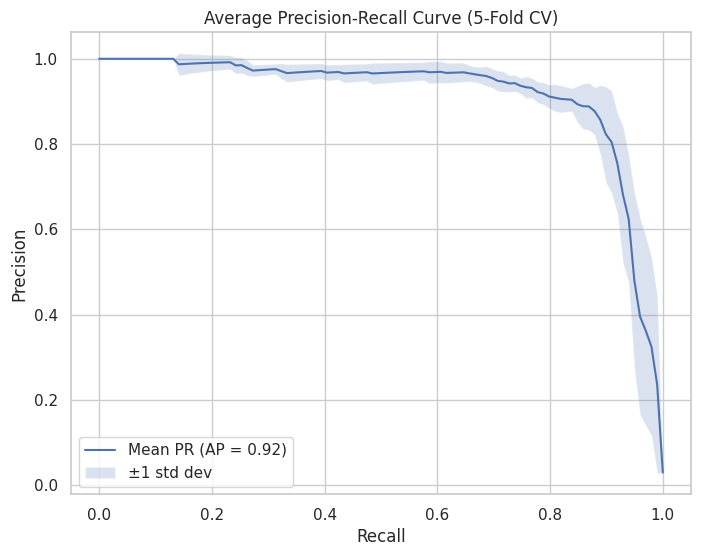

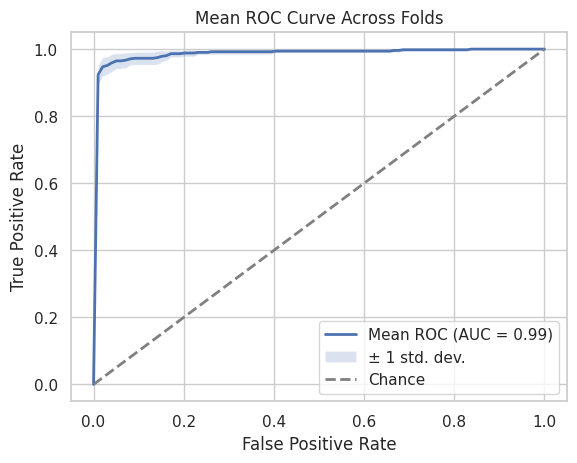


Overall Performance Across 5 Folds (Logistic Regression):
Average Precision: 0.9001 ± 0.0221
Average Recall:    0.8807 ± 0.0239
Average F1-score:  0.8903 ± 0.0218
Average ROC AUC:   0.9890 ± 0.0057


Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000, random_state=42))])

In [ ]:

smotomek_logreg(X, y)

[LightGBM] [Info] Number of positive: 3947, number of negative: 13336
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64678
[LightGBM] [Info] Number of data points in the train set: 17283, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.228375 -> initscore=-1.217511
[LightGBM] [Info] Start training from score -1.217511
Best F1 Threshold: 0.0229
Precision: 0.1222, Recall: 0.6471, F1: 0.2056
batch # 1

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      3354
           1       0.12      0.65      0.21       102

    accuracy                           0.85      3456
   macro avg       0.55      0.75      0.56      3456
weighted avg       0.96      0.85      0.90      3456


Confusion Matrix:
                 Predicted Negative  Predicted Positi

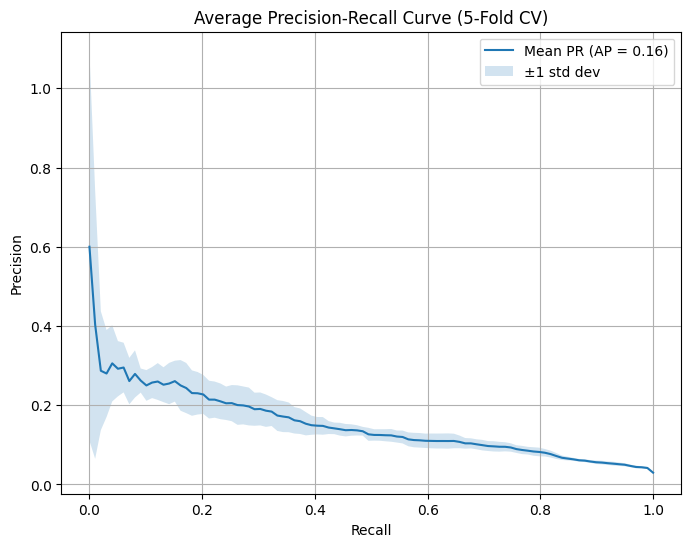

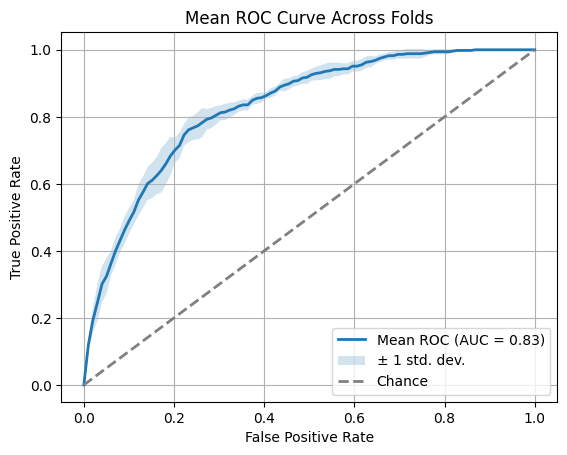


Overall Performance Across 5 Folds (LightGBM):
Average Precision: 0.1815 ± 0.0455
Average Recall:    0.4269 ± 0.1259
Average F1-score:  0.2406 ± 0.0308
Average ROC AUC:   0.8307 ± 0.0135


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=300,
               objective='binary', random_state=42, subsample=0.8)

In [ ]:
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def smotomek_lgbm(X, y):
    model = None
    X_clean = X.rename(columns=lambda col: col.replace('[', '_')
                                   .replace(']', '_')
                                   .replace('{', '_')
                                   .replace('}', '_')
                                   .replace(' ', '_')
                                   .replace('"', '_')
                                   .replace("'", '_')
                                   .replace(':', '_')
                                   .replace('\\', '_'))
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    recall_points = np.linspace(0, 1, 100)

    precision_list, recall_list, f1_list, roc_auc_list = [], [], [], []
    all_precisions, all_avg_precisions, all_tprs = [], [], []

    for batch_no, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X_clean.iloc[train_idx], X_clean.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        smt = SMOTETomek(sampling_strategy=0.3, random_state=42)
        X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

        model = lgb.LGBMClassifier(
            objective='binary',
            learning_rate=0.05,
            num_leaves=31,
            n_estimators=300,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )

        y_val_prob = compute_predictions(model, X_resampled, y_resampled, X_val)
        threshold = find_best_f1_threshold(y_val, y_val_prob)
        print(f"batch # {batch_no}")
        evaluation_metrics(y_val, y_val_prob, threshold, show_auc_plot=False)

        interp_precision, avg_precision, interp_tpr = interpolate_metrics(y_val, y_val_prob, recall_points)
        all_precisions.append(interp_precision)
        all_avg_precisions.append(avg_precision)
        all_tprs.append(interp_tpr)

        precision, recall, f1, auc_score = evaluate_threshold_metrics(y_val, y_val_prob, threshold)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        roc_auc_list.append(auc_score)

    plot_prec_recall(all_precisions, all_avg_precisions, recall_points)
    plot_mean_roc_curve(all_fpr=recall_points, all_tpr=all_tprs, fpr_points=recall_points)

    print("\nOverall Performance Across 5 Folds (LightGBM):")
    print(f"Average Precision: {np.mean(precision_list):.4f} ± {np.std(precision_list):.4f}")
    print(f"Average Recall:    {np.mean(recall_list):.4f} ± {np.std(recall_list):.4f}")
    print(f"Average F1-score:  {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")
    print(f"Average ROC AUC:   {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")
    return model

smotomek_lgbm(X, y)

Best F1 Threshold: 0.4319
Precision: 0.1623, Recall: 0.4902, F1: 0.2439
batch # 1

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      3354
           1       0.16      0.49      0.24       102

    accuracy                           0.91      3456
   macro avg       0.57      0.71      0.60      3456
weighted avg       0.96      0.91      0.93      3456


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                3096                 258
Actual Positive                  52                  50
ROC AUC: 0.8418803418803418

Predicted probabilities for true ADR 1:
       true      prob
417       1  0.406170
562       1  0.471142
780       1  0.353342
892       1  0.392851
1035      1  0.440803
...     ...       ...
16214     1  0.302370
16235     1  0.246503
16248     1  0.441937
16897     1  0.258604
17216     1  0.345642

[102 rows x 2 columns]

Non-ADR Predicted Prob

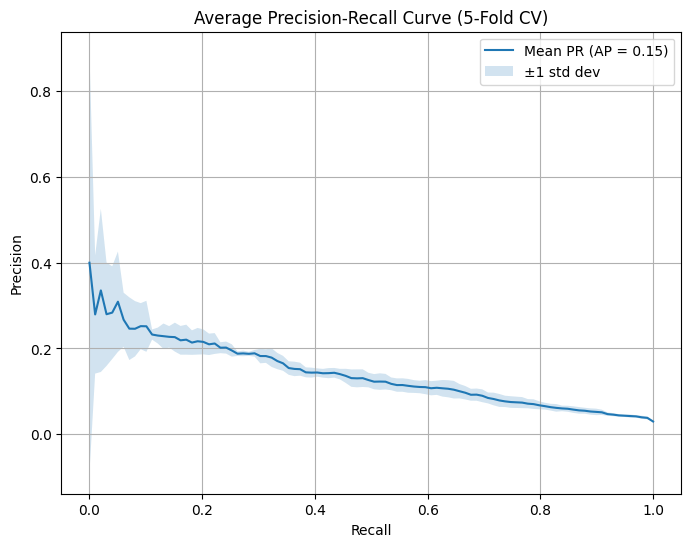

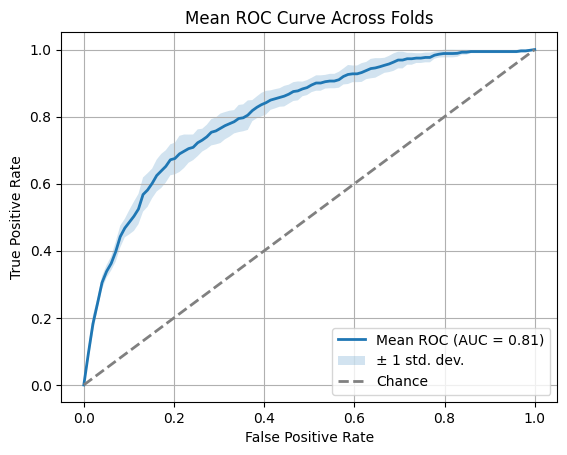


Overall Performance Across 5 Folds (AdaBoost):
Average Precision: 0.1940 ± 0.0357
Average Recall:    0.3719 ± 0.1006
Average F1-score:  0.2429 ± 0.0075
Average ROC AUC:   0.8104 ± 0.0198


AdaBoostClassifier(learning_rate=0.05, n_estimators=300, random_state=42)

In [ ]:

from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def smotomek_adaboost(X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    recall_points = np.linspace(0, 1, 100)

    precision_list, recall_list, f1_list, roc_auc_list = [], [], [], []
    all_precisions, all_avg_precisions, all_tprs = [], [], []
    model = None

    for batch_no, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        smt = SMOTETomek(sampling_strategy=0.3, random_state=42)
        X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

        model = AdaBoostClassifier(
            n_estimators=300,
            learning_rate=0.05,
            random_state=42
        )

        y_val_prob = compute_predictions(model, X_resampled, y_resampled, X_val)
        threshold = find_best_f1_threshold(y_val, y_val_prob)
        print(f"batch # {batch_no}")
        evaluation_metrics(y_val, y_val_prob, threshold, show_auc_plot=False)

        interp_precision, avg_precision, interp_tpr = interpolate_metrics(y_val, y_val_prob, recall_points)
        all_precisions.append(interp_precision)
        all_avg_precisions.append(avg_precision)
        all_tprs.append(interp_tpr)

        precision, recall, f1, auc_score = evaluate_threshold_metrics(y_val, y_val_prob, threshold)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        roc_auc_list.append(auc_score)

    plot_prec_recall(all_precisions, all_avg_precisions, recall_points)
    plot_mean_roc_curve(all_fpr=recall_points, all_tpr=all_tprs, fpr_points=recall_points)

    print("\nOverall Performance Across 5 Folds (AdaBoost):")
    print(f"Average Precision: {np.mean(precision_list):.4f} ± {np.std(precision_list):.4f}")
    print(f"Average Recall:    {np.mean(recall_list):.4f} ± {np.std(recall_list):.4f}")
    print(f"Average F1-score:  {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")
    print(f"Average ROC AUC:   {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")
    return model

smotomek_adaboost(X,y)

[LightGBM] [Info] Number of positive: 3947, number of negative: 13336
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64678
[LightGBM] [Info] Number of data points in the train set: 17283, number of used features: 408
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.228375 -> initscore=-1.217511
[LightGBM] [Info] Start training from score -1.217511
Best F1 Threshold: 0.2594
Precision: 0.1661, Recall: 0.4902, F1: 0.2481
batch # 1, Threshold: 0.2594

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      3354
           1       0.17      0.49      0.25       102

    accuracy                           0.91      3456
   macro avg       0.57      0.71      0.60      3456
weighted avg       0.96      0.91      0.93      3456


Confusion Matrix:
                 Predicted Negativ

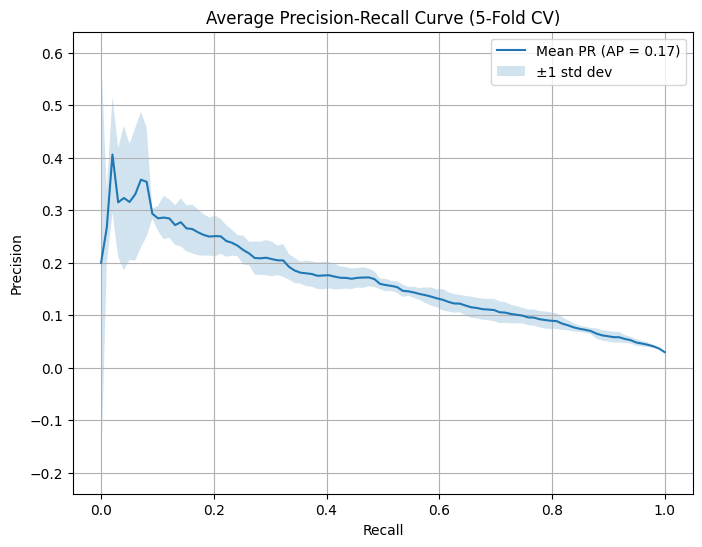

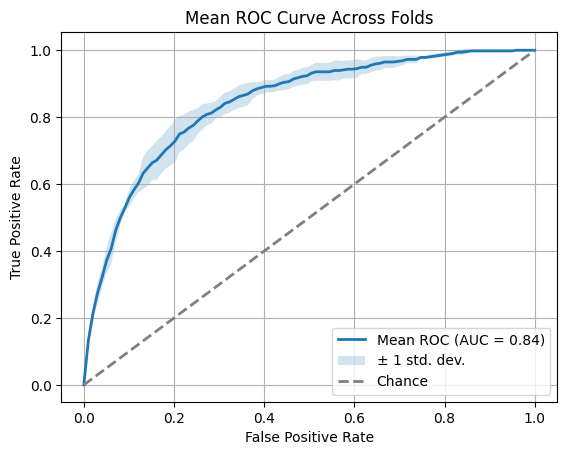


Overall Performance Across 5 Folds (Voting Ensemble):
Average Precision: 0.2283 ± 0.0486
Average Recall:    0.3679 ± 0.1040
Average F1-score:  0.2653 ± 0.0147
Average ROC AUC:   0.8420 ± 0.0177


In [ ]:
# # Ensemble voting
from sklearn.ensemble import VotingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.model_selection import StratifiedKFold
# import lightgbm as lgb
# import xgboost as xgb
# from imblearn.combine import SMOTETomek
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler

def smotomek_ensemble_voting(X, y):
    X_clean = X.rename(columns=lambda col: col.replace('[', '_')
                                   .replace(']', '_')
                                   .replace('{', '_')
                                   .replace('}', '_')
                                   .replace(' ', '_')
                                   .replace('"', '_')
                                   .replace("'", '_')
                                   .replace(':', '_')
                                   .replace('\\', '_'))
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    recall_points = np.linspace(0, 1, 100)

    precision_list, recall_list, f1_list, roc_auc_list = [], [], [], []
    all_precisions, all_avg_precisions, all_tprs = [], [], []

    for batch_no, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X_clean.iloc[train_idx], X_clean.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        smt = SMOTETomek(sampling_strategy=0.3, random_state=42)
        X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

        # Base models
        model_logreg = Pipeline([
            ("scaler", StandardScaler()),
            ("logreg", LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42))
        ])

        model_lgbm = lgb.LGBMClassifier(
            objective='binary',
            learning_rate=0.05,
            num_leaves=31,
            n_estimators=300,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )

        model_xgb = xgb.XGBClassifier(
            eval_metric='logloss',
            scale_pos_weight=1,
            learning_rate=0.05,
            max_depth=3,
            n_estimators=300,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )

        model_ada = AdaBoostClassifier(
            n_estimators=300,
            learning_rate=0.05,
            random_state=42
        )

        ensemble = VotingClassifier(
            estimators=[
                ('logreg', model_logreg),
                ('lgbm', model_lgbm),
                ('xgb', model_xgb),
                ('ada', model_ada)
            ],
            voting='soft'
        )

        y_val_prob = compute_predictions(ensemble, X_resampled, y_resampled, X_val)
        threshold = find_best_f1_threshold(y_val, y_val_prob)
        print(f"batch # {batch_no}, Threshold: {threshold:.4f}")
        evaluation_metrics(y_val, y_val_prob, threshold, show_auc_plot=False)

        interp_precision, avg_precision, interp_tpr = interpolate_metrics(y_val, y_val_prob, recall_points)
        all_precisions.append(interp_precision)
        all_avg_precisions.append(avg_precision)
        all_tprs.append(interp_tpr)

        precision, recall, f1, auc_score = evaluate_threshold_metrics(y_val, y_val_prob, threshold)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        roc_auc_list.append(auc_score)

    plot_prec_recall(all_precisions, all_avg_precisions, recall_points)
    plot_mean_roc_curve(all_fpr=recall_points, all_tpr=all_tprs, fpr_points=recall_points)

    print("\nOverall Performance Across 5 Folds (Voting Ensemble):")
    print(f"Average Precision: {np.mean(precision_list):.4f} ± {np.std(precision_list):.4f}")
    print(f"Average Recall:    {np.mean(recall_list):.4f} ± {np.std(recall_list):.4f}")
    print(f"Average F1-score:  {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")
    print(f"Average ROC AUC:   {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")
smotomek_ensemble_voting(X, y)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best F1 Threshold: 0.0012
Precision: 0.1344, Recall: 0.2451, F1: 0.1736
batch # 1

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      3354
           1       0.13      0.25      0.17       102

    accuracy                           0.93      3456
   macro avg       0.56      0.60      0.57      3456
weighted avg       0.95      0.93      0.94      3456


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                3193                 161
Actual Positive                  77                  25
ROC AUC: 0.696389736574415

Predicted probabilities for true ADR 1:
       true          prob
417       1  2.744494e-17
562       1  7.282931e-10
780       1  1.344767e-11
892       1  2.302865e-08
1035      1  1.913122e-35
...     ...           ...
16214     1  2.833585e-10
16235     1  0.000000e+00
16248     1  1.767797e-03
16897     1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best F1 Threshold: 0.0001
Precision: 0.1076, Recall: 0.2621, F1: 0.1525
batch # 2

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      3353
           1       0.11      0.26      0.15       103

    accuracy                           0.91      3456
   macro avg       0.54      0.60      0.55      3456
weighted avg       0.95      0.91      0.93      3456


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                3129                 224
Actual Positive                  76                  27
ROC AUC: 0.6894868817665096

Predicted probabilities for true ADR 1:
       true          prob
217       1  5.082662e-08
311       1  1.215376e-15
340       1  0.000000e+00
703       1  8.672065e-05
1221      1  1.920373e-22
...     ...           ...
15875     1  3.840854e-09
15882     1  2.655496e-05
16143     1  2.881621e-04
16402     

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Best F1 Threshold: 0.0002
Precision: 0.1364, Recall: 0.2353, F1: 0.1727
batch # 3

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3353
           1       0.14      0.24      0.17       102

    accuracy                           0.93      3455
   macro avg       0.56      0.59      0.57      3455
weighted avg       0.95      0.93      0.94      3455


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                3201                 152
Actual Positive                  78                  24
ROC AUC: 0.7422676795143945

Predicted probabilities for true ADR 1:
       true          prob
298       1  8.085415e-10
539       1  6.157930e-09
837       1  8.647998e-26
933       1  9.709268e-01
969       1  6.170704e-22
...     ...           ...
16655     1  6.695652e-07
16851     1  5.375677e-23
17169     1  8.051673e-12
17174     

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Best F1 Threshold: 0.0000
Precision: 0.1512, Recall: 0.3039, F1: 0.2020
batch # 4

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      3353
           1       0.15      0.30      0.20       102

    accuracy                           0.93      3455
   macro avg       0.56      0.63      0.58      3455
weighted avg       0.95      0.93      0.94      3455


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                3179                 174
Actual Positive                  71                  31
ROC AUC: 0.7457720039999298

Predicted probabilities for true ADR 1:
       true          prob
63        1  8.837987e-13
326       1  5.817524e-17
357       1  3.637256e-05
572       1  1.956393e-06
716       1  6.705071e-01
...     ...           ...
16130     1  9.516522e-14
16350     1  5.819855e-13
16503     1  4.028448e-05
16599     

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Best F1 Threshold: 0.0925
Precision: 0.2500, Recall: 0.1863, F1: 0.2135
batch # 5

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3353
           1       0.25      0.19      0.21       102

    accuracy                           0.96      3455
   macro avg       0.61      0.58      0.60      3455
weighted avg       0.95      0.96      0.96      3455


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                3296                  57
Actual Positive                  83                  19
ROC AUC: 0.7598960252159319

Predicted probabilities for true ADR 1:
       true          prob
200       1  1.026544e-05
355       1  9.930745e-06
461       1  1.611652e-17
578       1  0.000000e+00
681       1  1.486049e-13
...     ...           ...
16866     1  2.613606e-01
16896     1  1.052946e-02
16932     1  1.158202e-01
17089     

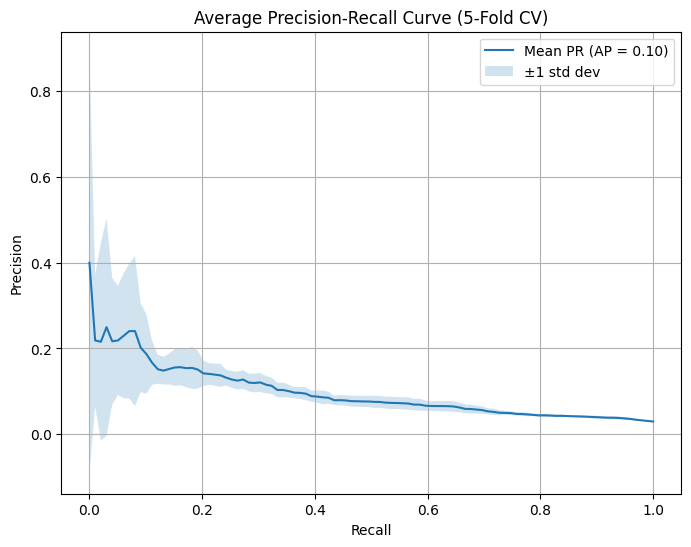

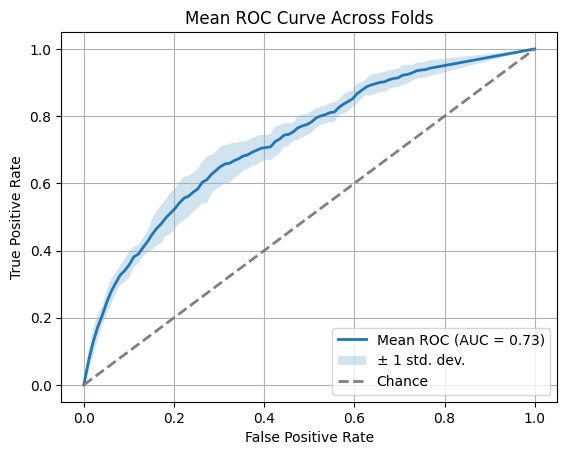


Overall Performance Across 5 Folds (MLP):
Average Precision: 0.1559 ± 0.0491
Average Recall:    0.2465 ± 0.0382
Average F1-score:  0.1829 ± 0.0220
Average ROC AUC:   0.7268 ± 0.0283


<Sequential name=sequential_9, built=True>

In [ ]:
from sklearn.model_selection import StratifiedKFold
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

def create_mlp_model(input_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
    return model

def smotomek_mlp(X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    recall_points = np.linspace(0, 1, 100)

    precision_list, recall_list, f1_list, roc_auc_list = [], [], [], []
    all_precisions, all_avg_precisions, all_tprs = [], [], []
    model = None

    for batch_no, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # SMOTETomek resampling
        smt = SMOTETomek(sampling_strategy=0.3, random_state=42)
        X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

        # Scale features
        scaler = StandardScaler()
        X_resampled = scaler.fit_transform(X_resampled)
        X_val_scaled = scaler.transform(X_val)

        # Define MLP model
        model = create_mlp_model(input_dim=X.shape[1])

        # Train model
        early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        model.fit(X_resampled, y_resampled, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])

        # Predict probabilities
        y_val_prob = model.predict(X_val_scaled).ravel()

        threshold = find_best_f1_threshold(y_val, y_val_prob)
        print(f"batch # {batch_no}")
        evaluation_metrics(y_val, y_val_prob, threshold, show_auc_plot=False)

        interp_precision, avg_precision, interp_tpr = interpolate_metrics(y_val, y_val_prob, recall_points)
        all_precisions.append(interp_precision)
        all_avg_precisions.append(avg_precision)
        all_tprs.append(interp_tpr)

        precision, recall, f1, auc_score = evaluate_threshold_metrics(y_val, y_val_prob, threshold)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        roc_auc_list.append(auc_score)

    plot_prec_recall(all_precisions, all_avg_precisions, recall_points)
    plot_mean_roc_curve(all_fpr=recall_points, all_tpr=all_tprs, fpr_points=recall_points)

    print("\nOverall Performance Across 5 Folds (MLP):")
    print(f"Average Precision: {np.mean(precision_list):.4f} ± {np.std(precision_list):.4f}")
    print(f"Average Recall:    {np.mean(recall_list):.4f} ± {np.std(recall_list):.4f}")
    print(f"Average F1-score:  {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")
    print(f"Average ROC AUC:   {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")
    return model

smotomek_mlp(X, y)